In [1]:
%pip install "git+https://github.com/jsbrittain/saccadapt.git#subdirectory=eye"
%pip install pingouin
%pip install XlsxWriter
import os
import eye as Eye
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pingouin
import xlsxwriter
from typing import List
from dataclasses import dataclass
matplotlib.use('nbagg')

%matplotlib inline

  Cloning https://github.com/jsbrittain/saccadapt.git to /tmp/pip-req-build-gm8ntcn_
  Running command git clone --filter=blob:none --quiet https://github.com/jsbrittain/saccadapt.git /tmp/pip-req-build-gm8ntcn_
  Resolved https://github.com/jsbrittain/saccadapt.git to commit 3911525b483fb4a805b6de5b6ab72b9920b7635a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for eye: filename=eye-0.1.0-py3-none-any.whl size=4035 sha256=4fd1a18699d5531b8d34b7f11e4eb548b735c06a3497e489d56b70888a3629fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-1vb31ahu/wheels/9e/c3/b9/73ffd62f0351151da04a178477d4ac9d85ead39e97c8d5228e
Successfully built eye
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.3 MB/s eta 0:00:00


## Mount Google Drive then load eyelink data

Remove this section if you are uploading files manually.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

@dataclass
class FileEntry:
  filename: str = ""
  group: str = ""

  def __init__(self, filename, group):
    self.filename = filename
    self.group = group

root = 'drive/MyDrive/sacc.adapt.data/asc/'
folderlist = os.listdir(root)
filelist = [
    FileEntry(
        root + filename,
        '-'.join(filename.split('.')[0].split('_')[1:]).upper(),
    ) for filename in folderlist
]

eyelist = []
for file in filelist:
  filename = file.filename
  print("Loading filename: ", filename)
  try:
    data = Eye.Eye(filename)
  except Exception as e:
    print("Error: ", e)
    continue
  data.filename = filename
  data.label = filename.split('/')[-1].split('.')[0]
  data.group = file.group
  eyelist.append(data)

Mounted at /content/drive
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/.ipynb_checkpoints
Error:  [Errno 21] Is a directory: 'drive/MyDrive/sacc.adapt.data/asc/.ipynb_checkpoints'
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/AB_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/AC_50_M.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/AM_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/AR2_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/BP_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/BW_50_M.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/CP_50_M.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/EM_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/ES_50_m.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/HP_50_M.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/IK_50_M.asc
Loading filename:  drive/MyDrive/sacc.adapt.data/asc/JS_50_M.asc
Loading filename:  drive/MyDriv

### Examine channel data

Select the eyelink data loaded from the above filename list.

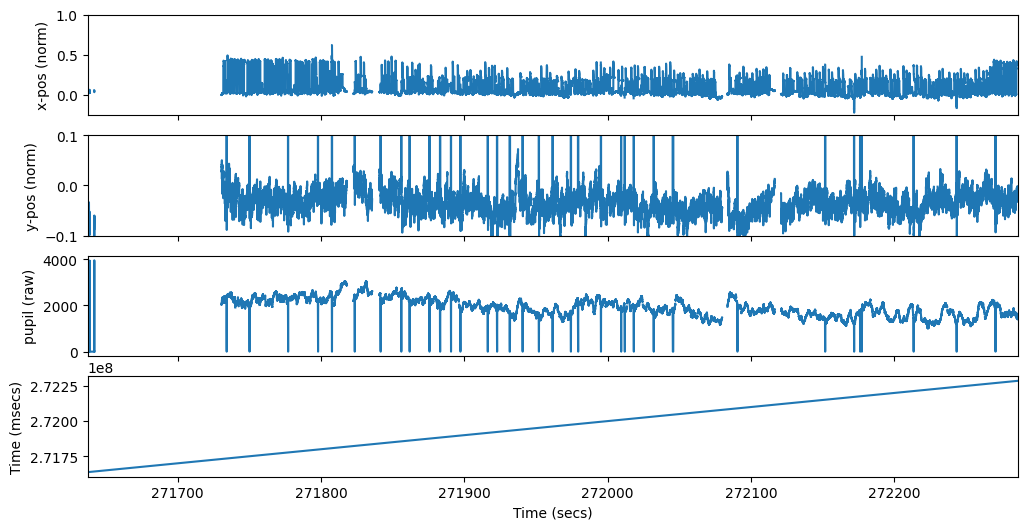

In [3]:
eye = eyelist[0];  # eyelist[0] = first entry in filenames list

time_secs = eye.data['Time (msecs)']/1000
fig, axs = plt.subplots(len(eye.data.columns), figsize=(12, 6), sharex=True)
for k, colname in enumerate(eye.data.columns):
    axs[k].plot(time_secs, eye.data[colname])
    axs[k].set_ylabel(colname)
axs[0].set_xlim(time_secs.iloc[0], time_secs.iloc[-1])

axs[0].set_ylim(-0.25, 1.0)
axs[1].set_ylim(-0.1, 0.1)
# axs[2].set_ylim(600, 2000)
axs[3].set_xlabel('Time (secs)')
fig.show()

### xy-trace

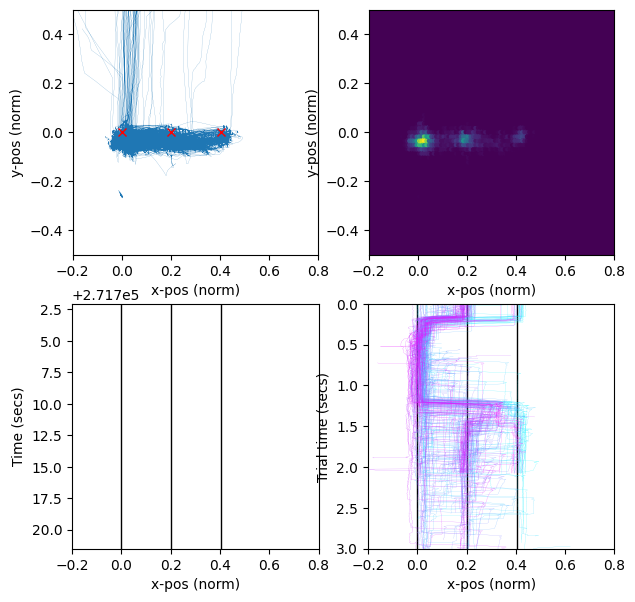

In [4]:
eye = eyelist[0];  # eyelist[0] = first entry in filenames list

chx, chy = 'x-pos (norm)', 'y-pos (norm)'  # x, y

fig, axs = plt.subplot_mosaic(
    [['b','c'], ['a','d']],
    figsize=(7, 7),
)

# temporal segment
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['a'].plot(np.array([x, x]), [time_secs.iloc[0], time_secs.iloc[-1]], 'k-', linewidth=1)
axs['a'].plot(eye.data[chx], time_secs)
for start, end in zip(eye.trial.StartPos, eye.trial.EndPos):
  axs['a'].plot(np.array([-1, 1]), np.array([start, start])/eye._SAMPLE_RATE, 'k-', linewidth=0.5)
axs['a'].set_xlim(-0.2, 0.8)
axs['a'].set_xlabel(chx)
axs['a'].set_ylabel('Time (secs)')
axs['a'].set_ylim(
    time_secs.iloc[round(0.100*len(time_secs))],
    time_secs.iloc[round(0.130*len(time_secs))],
)
axs['a'].invert_yaxis()

# xy-trace
axs['b'].plot(eye.data[chx], eye.data[chy], linewidth=0.1)
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['b'].plot(x, y, 'rx')
axs['b'].set_aspect('equal', 'box')
axs['b'].set_xlim(-0.2, 0.8)
axs['b'].set_ylim(-0.5, 0.5)
axs['b'].set_xlabel(chx)
axs['b'].set_ylabel(chy)

# spatial histogram
axs['c'].hexbin(
    eye.data[chx],
    eye.data[chy],
    extent=(-0.2, 0.8, -0.5, 0.5),
)
axs['c'].set_aspect('equal', 'box')
axs['c'].set_xlim(-0.2, 0.8)
axs['c'].set_ylim(-0.5, 0.5)
axs['c'].set_xlabel(chx)
axs['c'].set_ylabel(chy)

# stack trials
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['d'].plot(np.array([x, x]), np.array([0.0, 3.0]), 'k-', linewidth=1)
viridis = matplotlib.colormaps['cool']
for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
  axs['d'].plot(
      eye.data[chx].loc[start:end],
      time_secs.loc[start:end]-time_secs.loc[start],
      '-',
      linewidth=0.1,
      color=viridis(index/(len(eye.trial)-1)),
  )
axs['d'].set_ylabel('Trial time (secs)')
axs['d'].set_xlabel(chx)
axs['d'].set_xlim(-0.2, 0.8)
axs['d'].set_ylim(0, 3)
axs['d'].invert_yaxis()

fig.show()

## Extract per-trial metrics

In [60]:
convert_to_error = True

# Loop over filenames
for eye in eyelist:
  # Loop over trials
  eye.trial['max_x'] = [0]*len(eye.trial)
  for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
    eye.trial['max_x'].at[index] = max(eye.data[chx].loc[start:end])

  # Metric
  data = eye.trial['max_x']

  # Bin data, reject single-trials based on binned SD (per subject)
  binwidth = 10
  reject_count = 0
  for bin in range(len(data)//binwidth):
    tt = bin*binwidth + np.array(range(binwidth))
    bin_mu = np.mean(data[tt])
    bin_sd = np.std(data[tt])
    reject = np.abs(data[tt] - bin_mu) > 2 * bin_sd
    reject_count += np.sum(reject)
    data[tt[reject]] = np.nan

  # Interpolate over removed values
  data = data.interpolate()

  # Convert deviation to error
  if convert_to_error:
    target_positions = [t[1][0] for index in eye.trial.index for t in eye.trial['Targets'].loc[index]]
    target_positions = np.sort(np.unique(target_positions))
    xtrans = lambda x: 2 * (x / eye._DISPLAY_COORDS[0] - 0.5)
    data[0:30] = data[0:30] - xtrans(target_positions[2])
    data[30:180] = data[30:180] - xtrans(target_positions[1])
    data[180:190] = data[180:190] - xtrans(target_positions[2])

  # Save data
  eye.avg = data
  eye.reject_count = reject_count

  # Area under the curve calculation
  eye.auc = np.array([
      np.mean(eye.avg[0:30]),  # watch-out for python array indexing here
      np.mean(eye.avg[30:180]),
      np.mean(eye.avg[180:190]),
  ])

## Area-under-the-curve (AUC) analysis

Analyses are performed on un-smoothed data.

Note that we switch to seaborn for visualisation here.

One-way ANOVA results are also provided. These can be extended as needed.

        Source     SS  DF1  DF2     MS        F  p-unc    np2    eps
0        Group  0.006    3   71  0.002    0.434  0.729  0.018    NaN
1        Stage  0.782    2  142  0.391  164.440  0.000  0.698  0.944
2  Interaction  0.022    6  142  0.004    1.545  0.168  0.061    NaN


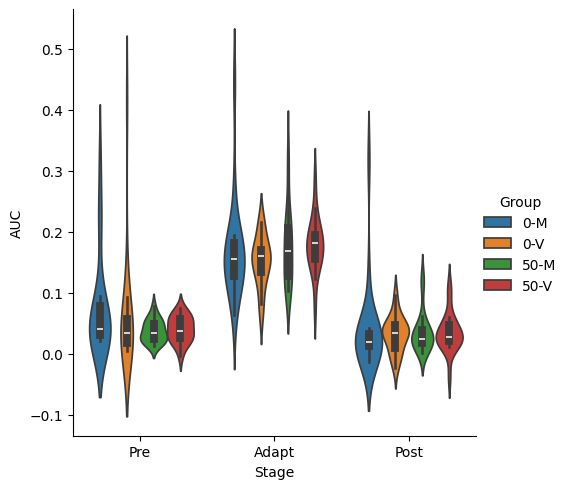

In [61]:
# Collate AUC into dataframe
groupdata = pd.DataFrame(
    [[eye.label, eye.group, k, eye.auc[k]] for eye in eyelist for k in range(len(eye.auc))],
    columns=['Subject', 'Group', 'Stage', 'AUC']
  )
groupdata['Group'] = groupdata['Group'].astype('category')
groupdata['Stage'] = groupdata['Stage'].astype('category').cat.rename_categories({0: 'Pre', 1: 'Adapt', 2: 'Post'})

# Violin plot
sns.catplot(data=groupdata, x="Stage", y="AUC", hue="Group", kind="violin")

# Mixed ANOVA
aov = pingouin.mixed_anova(dv='AUC', between='Group', within='Stage', subject='Subject', data=groupdata)
print(aov.round(3))

In [62]:
# Write data to files (individuals)
for eye in eyelist:
  eye.avg.to_csv(f'{root}/results/avg_{eye.label}.csv')

# Output to Excel
print("Collating Excel file...")
workbook = xlsxwriter.Workbook(f'{root}/results/collated.xlsx')
groups = set([eye.group for eye in eyelist])
for group in groups:
  print(f" Group: {group}")
  worksheet = workbook.add_worksheet(group)
  col = 0
  for eye in eyelist:
    if eye.group == group:
      # Add to workbook
      row = 0
      for item in eye.avg:
        if not np.isnan(item):  # leave a space if nan
          worksheet.write(row, col, item)
        row += 1
      col += 1
workbook.close()
print("done.")

## Plot group averages

Smoothing can be applied over time here (only applies to plot)

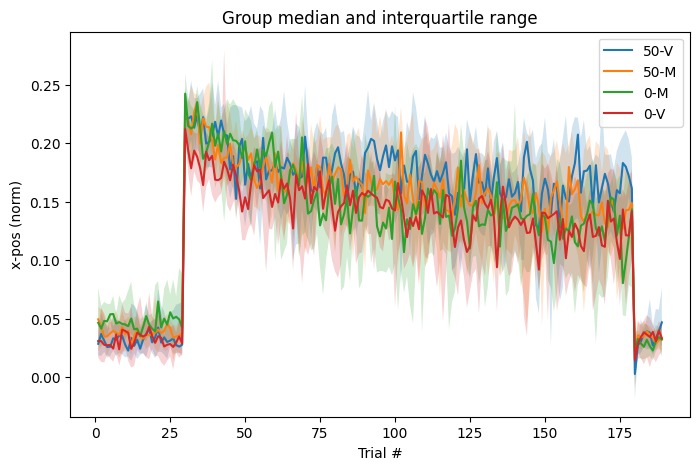

In [50]:
smoothing = 1
parametric_plot = False

# Smoothing function
def smooth(y, box_pts):
  if box_pts == 1:
    return y, np.zeros_like(y)
  hl = (box_pts-1)//2
  y_avg = 0.*y
  y_sd = 0.*y
  for t, _ in enumerate(y):
    tt = np.arange(t-hl, t+hl)
    tt = tt[tt>=0]
    tt = tt[tt<len(y)]
    y_avg[t] = np.mean(y[tt])
    y_sd[t] = np.std(y[tt])

  return y_avg, y_sd

# Plot group averages
fig, axs = plt.subplots(1, figsize=(8, 5), sharex=True)
groups = set([eye.group for eye in eyelist])
groupcolour = []
avg = {}
med = {}
std = {}
sem = {}
qlow = {}
qhigh = {}
for group in groups:
  grp_data = np.array([smooth(eye.avg, smoothing)[0] for eye in eyelist if eye.group == group])
  avg[group] = np.mean(grp_data, 0)
  med[group] = np.median(grp_data, 0)
  std[group] = np.std(grp_data, 0)
  sem[group] = std[group]/np.sqrt(grp_data.shape[0])
  qlow[group] = np.quantile(grp_data, 0.25, 0)
  qhigh[group] = np.quantile(grp_data, 0.75, 0)

  if parametric_plot:
    axs.fill_between(range(len(avg[group])), avg[group] - sem[group], avg[group] + sem[group], alpha=0.2)
    label = "Group average data [+/- 1xSEM]"
    gc, = axs.plot(avg[group], label=group)
    groupcolour.append(gc)
  else:
    axs.fill_between(range(len(med[group])), qlow[group], qhigh[group], alpha=0.2)
    label = "Group median and interquartile range"
    gc, = axs.plot(med[group], label=group)
    groupcolour.append(gc)

xlabel = chx
if convert_to_error:
  xlabel += " error"

# axs.set_ylim([0.25, 0.65])
axs.set_ylabel(chx)
axs.set_xlabel("Trial #")
axs.set_title(label)
axs.legend()
fig.show()

[ 960 1153 1349]


Text(0.5, 1.0, 'Inward target delay relative to start of saccade (median=56.0 msecs)')

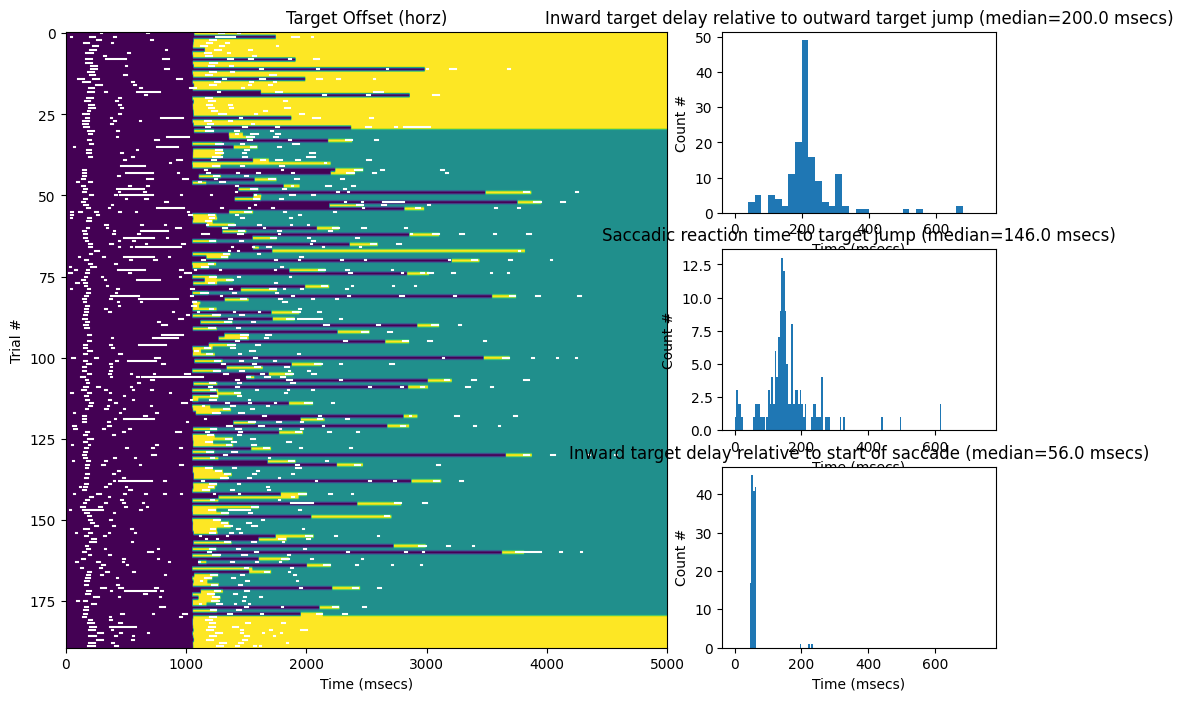

In [9]:
eye = eyelist[0];  # eyelist[0] = first entry in filenames list

# Auto-determine target locations
# alternatively, try target_positions = [960, 1349, 1153]
target_positions = [t[1][0] for index in eye.trial.index for t in eye.trial['Targets'].loc[index]]
target_positions = np.sort(np.unique(target_positions))
print(target_positions)

# Loop over trials
fig, axs = plt.subplot_mosaic(
    [['a','a','b'], ['a','a','c'], ['a','a','d']],
    figsize=(12, 8),
)
count = 0
max_samples = 5000
x = 960 * np.ones((len(eye.trial), max_samples))
x_mean = np.zeros(max_samples)
inward_delay = []
sacc_delay = []
sacc_rt = []
for index in eye.trial.index:
  targets = eye.trial['Targets'].loc[index]
  last_target_time = 0
  outward_time, inward_time = 0, 0
  for t in targets:
    target_time, target_pos = int(t[0]-eye.trial['StartPos'].loc[index]), t[1]
    assert target_time > last_target_time
    last_target_time = target_time
    x[index, target_time:] = target_pos[0]
    if target_pos[0] == target_positions[2]:
      outward_time = target_time
    if target_pos[0] == target_positions[1]:
      inward_time = target_time
      assert inward_time > outward_time
      inward_delay.append(target_time - outward_time)
  # First saccade after outward_time
  saccades = eye.trial['Saccades'].loc[index]
  if inward_time > 0 and outward_time > 0:
    for sacc in saccades:
      sacc_time = sacc[0] - eye.trial['StartPos'].loc[index]
      if sacc_time > outward_time:
        sacc_delay.append(inward_time - sacc_time)
        sacc_rt.append(sacc_time - outward_time)
        break

offset = 0.0
plot_saccades = True
plot_fixations = False

axs['a'].imshow(x, aspect='auto')
for index in eye.trial.index:
  if plot_saccades:
    saccades = eye.trial['Saccades'].loc[index]
    for sacc in saccades:
      axs['a'].plot([
          sacc[0] - eye.trial.StartPos.loc[index],
          sacc[1] - eye.trial.StartPos.loc[index]],
          [index - offset, index - offset], 'w-')
  if plot_fixations:
    fixations = eye.trial['Fixations'].loc[index]
    for fix in fixations:
      axs['a'].plot([
          fix[0] - eye.trial.StartPos.loc[index],
          fix[1] - eye.trial.StartPos.loc[index]],
          [index + offset, index + offset], 'r-')
axs['a'].set_xlim(0, 5000)
axs['a'].set_xlabel('Time (msecs)')
axs['a'].set_ylabel('Trial #')
axs['a'].set_title("Target Offset (horz)")

axs['b'].hist(inward_delay, range(0, 750, 20))
axs['b'].set_xlabel('Time (msecs)')
axs['b'].set_ylabel('Count #')
axs['b'].set_title(f"Inward target delay relative to outward target jump (median={np.median(inward_delay)} msecs)")

axs['c'].hist(sacc_rt, range(0, 750, 5))
axs['c'].set_xlabel('Time (msecs)')
axs['c'].set_ylabel('Count #')
axs['c'].set_title(f"Saccadic reaction time to target jump (median={np.median(sacc_rt)} msecs)")

axs['d'].hist(sacc_delay, range(0, 750, 5))
axs['d'].set_xlabel('Time (msecs)')
axs['d'].set_ylabel('Count #')
axs['d'].set_title(f"Inward target delay relative to start of saccade (median={np.median(sacc_delay)} msecs)")